## Week 9: Defining Functions and Moving Windows

In developing our TTR calculations, we learned that the non-standardized TTRs can't be compared to each other because the value of the TTR is highly dependent of the length of the text.  This is due to the fact that langauges include connective words that are repeated many times, so longer texts will have smaller TTR values than shorter texts.

We addressed this issue by standardizing the texts so that each text we want to compare is the same length. Our method of standardizing was to find the smallest text and then truncate each text to that size.  This means that our TTR anlyses have only evaluated the first part of many texts.

There is a clear question here, whether the TTR of the first portion of a text is a reasonable representation of the TTR of the full text. In other words, would we get a substantially different TTR value if we chose a different portion of the text to compute the TTR.

Let's dig into this question further, by looking at the concept of moving averages.  But before we get to moving averages, we need to know how to write a function.

For more information on writing a function, please see Walsh's section on [functions](https://melaniewalsh.github.io/Intro-Cultural-Analytics/02-Python/12-Functions.html)

You already know how to use functions.  Examples of functions that we have used are `print()`, `len()`, `type()`.  You can define your own function using the syntax below. There are two main reasons to write functions:
- To package up a set of operations so that you don't have to think about the details
- To package up a set of operations that will be repeated with different arguments.

Functions take one or more "arguments". The argument to `len()` is the object (string or list) that we want to find the length of.

They also often "return" a value that we can assign to a variable or use in other ways.  The function `len()` returns an integer that is the length of the argument.

For example, let's write a function that takes a string (say the text from a book) and returns a list of words that have the punctuation removed all the words converted to lower case.

In [ ]:
import re
def clean_tokens(text):
    ''' Return a list of words extracted from text where punctuation has been removed and all characters have been converted to lower case.
    Example:
    >>> clean_tokens("How's it going?")
    ['how', 's', 'it', 'going']
    '''
    cleaned_text = text.lower()
    cleaned_text = re.sub("[^a-zA-Z0-9]", " ", cleaned_text)
    tokens = cleaned_text.split()
    return tokens


In [ ]:
# Now let's try calling our new function
clean_tokens("How's it going")



We could argue about whether packaging these operations into a function is really useful or not. Does it make the code more readable?

But let's get back to the question of a moving window to compute an average TTR for a given window size. The window size is the number of tokens we will use to investigate, and we shift the window across the list of tokens and compute the TTR for each step.

I'm going to use as an example the first line from Dr. Seuss's "One Fish, Two Fish" book:

> One fish, Two fish, Red fish, Blue fish,

`['one', 'fish', 'two', 'fish', 'red', 'fish', 'blue', 'fish']`

For the record, the TTR of these two lines is 62.5% (5/8 * 100)

Now suppose we want to use a moving window size of 3. Note that the window size determines the number of tokens.
- First window is `['one', 'fish', 'two']` which has a 3 types.
- Second window is `['fish', 'two', 'fish']` which has 2 types
- Third winodw is `['two', 'fish', 'red']` which has 3 types
- Fourth window is `['fish', 'red', 'fish']` which has 2 types
- Fifth window is `['red', 'fish', 'blue']` which has 3 types
- Sixth window is `['fish', 'blue', 'fish']` which has 2 types

We can now compute the average of the types to get the average TTR with a window size of 3 which is 83.3%

This can be computed in a few different ways.  Here are two:
- Average of the TTRs: `(3/3 + 2/3 + 3/3 + 2/3 + 3/3 + 2/3) /6 * 100`
- Average the types and then compute the TTR: `(3 + 2 + 3 + 2 + 3 + 2)/ (3 * 6) * 100`

The purpose of this example is to illustrate a moving window, but we can start to think about what useful window sizes might be.

In [ ]:
print(clean_tokens("One fish, Two fish, Red fish, Blue fish,"))

Let's write a function to compute the moving window TTR where the window size is an argument.  This will allow us to experiment with different window sizes.

In [ ]:
def moving_TTR(tokens, window_size):
    """ Return the average TTR for tokens given a window size of window_size
        If window_size is greater than the length of tokens return 0
    """
    if window_size > len(tokens):
        return 0
    
    # The starting index for a particular window
    window_start = 0
    types_sum = 0

    # loop over each window by incrementing window_start
    while window_start <= len(tokens) - window_size:

        # comput the types for this window
        unique_words = []
        for index in range(window_start, window_start + window_size):
            if tokens[index] not in unique_words:
                unique_words.append(tokens[index])

        # add the number of types for this window to our sum
        types_sum = types_sum + len(unique_words)
        window_start += 1

    # compute the average
    num_windows = len(tokens) - window_size + 1
    average_ttr = types_sum / (num_windows * window_size) * 100
    return average_ttr

moving_TTR(['one', 'fish', 'two', 'fish', 'red', 'fish', 'blue', 'fish'], 3)

Unfortunately, this is a tremendously inefficient implementation. When I tried to run this on the whole CSAL data set on my own computer, computing the windows for the first book took about 10 minutes. My estimate of how long it might take to run the full set was about 16 hours!! 

Here is an implementation of the same function that doesn't completely recompute the  number of types on each iteration of the loop. This radically improves the speed to about 15 seconds for the full CSAL data set!!  This implementation keeps track of the frequency of each word in a window using the Counter type.  This means that on each subsequent iteration, we can update the number of types by removing the token that left the set and adding the new token that we added.

In [1]:
from collections import Counter

def moving_TTR(tokens, window_size):
    n = len(tokens)
    if window_size <= 0 or window_size > n:
        return 0

    # initialize first window
    window = tokens[:window_size]
    counts = Counter(window)            # word -> frequency in current window
    # counts is a dictionary that maps each distint work in window to the number of times that word appears

    num_types = len(counts)              # number of types in current window
    types_sum = num_types

    # slide the window once per step
    for i in range(window_size, n):
        out_tok = tokens[i - window_size]
        in_tok  = tokens[i]

        # remove leftmost token
        counts[out_tok] -= 1
        if counts[out_tok] == 0:
            del counts[out_tok]
            num_types -= 1

        # add rightmost token
        prev = counts.get(in_tok, 0)
        counts[in_tok] = prev + 1
        if prev == 0:
            num_types += 1

        types_sum += num_types

    num_windows = n - window_size + 1
    return types_sum / (num_windows * window_size) * 100

moving_TTR(['one', 'fish', 'two', 'fish', 'red', 'fish', 'blue', 'fish'], 8)

62.5

In [ ]:
import re
from pathlib import Path

folder_path = "csal/" # We're telling the code to look in the "csal/" subfolder, where the CSAL files all live.

# Open the output file and write the headers
file = open("ttr-windows.csv", mode="w", encoding="utf-8")

file.write('"Text","Total Tokens","TTR 500","TTR 1000","TTR 2000","TTR 4051"\n') 
windows = [500, 1000, 2000, 4051]

for file_path in sorted(Path(folder_path).glob('*.txt')):
    text = open(file_path, encoding='utf-8').read()
    text = re.sub("[^a-zA-Z0-9]", " ", text)
    text = text.lower()
    
    text_words = text.split()
    # write the start of this line to the file
    file.write(f'"{file_path.name}", {len(text_words)}')

    # compute and write each ttr to the file
    for window_size in windows:
        print(f"Computing window size {window_size} for {file_path.name}")
        ttr = moving_TTR(text_words, window_size)
        file.write(f',{ttr:.2f}')
    file.write('\n')

file.close()

Computing window size 500 for 1897-Alice-Macdonald-Fleming-A-Pinchbeck-Goddess-1897-fiction.txt
Computing window size 1000 for 1897-Alice-Macdonald-Fleming-A-Pinchbeck-Goddess-1897-fiction.txt
Computing window size 2000 for 1897-Alice-Macdonald-Fleming-A-Pinchbeck-Goddess-1897-fiction.txt
Computing window size 4051 for 1897-Alice-Macdonald-Fleming-A-Pinchbeck-Goddess-1897-fiction.txt
Computing window size 500 for Alice-Elizabeth-Dracott-Simla-Village-Tales-or-Folk-Tales-from-the-Himalayas-1906-fiction.txt
Computing window size 1000 for Alice-Elizabeth-Dracott-Simla-Village-Tales-or-Folk-Tales-from-the-Himalayas-1906-fiction.txt
Computing window size 2000 for Alice-Elizabeth-Dracott-Simla-Village-Tales-or-Folk-Tales-from-the-Himalayas-1906-fiction.txt
Computing window size 4051 for Alice-Elizabeth-Dracott-Simla-Village-Tales-or-Folk-Tales-from-the-Himalayas-1906-fiction.txt
Computing window size 500 for Annie-Besant-The-Case-for-India-1917-Nonfiction.txt
Computing window size 1000 for A

## Research question

There is one book where the TTR average over the moving window is very different than standardized TTR.  Let's investigate why.

In [17]:
from collections import Counter

book = open("csal/M-Frere-Old-Deccan-Days-or-Hindoo-Fariy-Legends-Current-in-Southern-India-1870-Fiction.txt", encoding='utf-8').read()
book = re.sub("[^a-zA-Z0-9]", " ", book)
book = book.lower()
tokens = book.split()
window_size = 4051
ttr_list = []
 
# The starting index for a particular window
window_start = 0

# initialize first window
window = tokens[:window_size]
counts = Counter(window)            # word -> frequency in current window
# counts is a dictionary that maps each distint work in window to the number of times that word appears

num_types = len(counts)              # number of types in current window
ttr_list.append(num_types/window_size *100)
types_sum = num_types
n = len(tokens)

# slide the window once per step
for i in range(window_size, n):
    out_tok = tokens[i - window_size]
    in_tok  = tokens[i]

    # remove leftmost token
    counts[out_tok] -= 1
    if counts[out_tok] == 0:
        del counts[out_tok]
        num_types -= 1

    # add rightmost token
    prev = counts.get(in_tok, 0)
    counts[in_tok] = prev + 1
    if prev == 0:
        num_types += 1
    if i % 100 == 0:
        ttr_list.append(num_types/window_size *100)
    types_sum += num_types

num_windows = n - window_size + 1
average_ttr = types_sum / (num_windows * window_size) * 100
print(ttr_list)
  


[33.59664280424586, 33.44853122685756, 33.053567020488764, 32.28832387064922, 32.18958281905702, 31.967415452974574, 31.646507035299926, 31.350283880523328, 31.05406072574673, 30.90594914835843, 31.10343125154283, 30.708467045174032, 30.436929153295484, 29.992594421130587, 29.64700074055789, 29.37546284867934, 29.202666008392992, 29.153295482596892, 28.931128116514444, 28.906442853616394, 28.610219698839796, 28.264626018267098, 27.919032337694393, 27.301900765243147, 26.85756603307825, 26.289804986423103, 25.771414465564057, 25.32707973339916, 24.808689212540113, 24.191557640088867, 23.62379659343372, 23.17946186126882, 22.710441866205873, 22.340162922735125, 21.969883979264377, 21.920513453468278, 21.77240187607998, 21.846457664774128, 21.45149345840533, 21.229326092322882, 21.155270303628733, 20.982473463342384, 21.229326092322882, 20.908417674648234, 20.883732411750184, 21.031843989138483, 20.859047148852135, 21.204640829424832, 21.278696618118982, 21.007158726240434, 20.68625030856

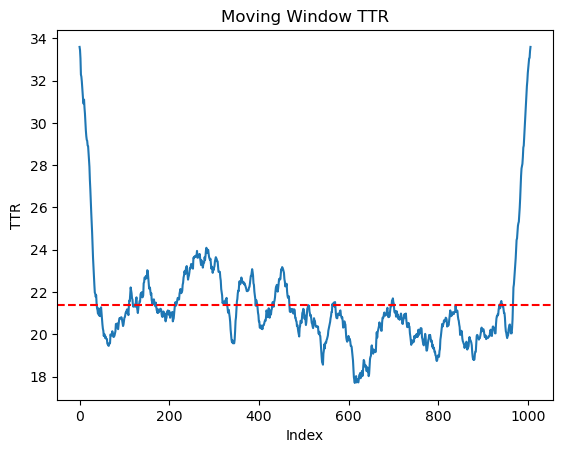

In [18]:
import matplotlib.pyplot as plt
plt.plot(ttr_list)
plt.title("Moving Window TTR")
plt.xlabel("Index")
plt.ylabel("TTR")

plt.axhline(average_ttr, color='red', linestyle='--', label=f'Average = {average_ttr:.2f}')

plt.show()